<a href="https://colab.research.google.com/github/macbhaldar/Predicting-Electricity-Demand/blob/main/Predicting_Electricity_Demand_Predicting_Electricity_Demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score

### Load Feature-Engineered Dataset

In [2]:
df = pd.read_csv("electricity_demand_features.csv")
df.head()

,day,hour,time_normalized,sin_time,cos_time,temp,is_weekend,measured_demand
0,0,0.0,0.000000,0.000000,1.000000,25.745071,0,2.904928
1,0,0.5,0.020833,0.130526,0.991445,25.836813,0,3.321722
2,0,1.0,0.041667,0.258819,0.965926,28.042085,0,3.488050
3,0,1.5,0.062500,0.382683,0.923880,30.346012,0,3.534498
4,0,2.0,0.083333,0.500000,0.866025,28.648770,0,4.059016


### Define Features and Target

In [3]:
X = df[
    ["time_normalized", "sin_time", "cos_time", "temp", "is_weekend"]
].values

y = df["measured_demand"].values

### Train-Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42
)

### Feature Scaling

In [5]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Define GPR Kernel

In [6]:
kernel = (
    ConstantKernel(1.0, (1e-2, 1e2)) *
    RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) +
    WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 1e1))
)

### Train Gaussian Process Model

In [7]:
gpr = GaussianProcessRegressor(
    kernel=kernel,
    alpha=0.0,
    normalize_y=True,
    n_restarts_optimizer=5,
    random_state=42
)

gpr.fit(X_train_scaled, y_train)

GaussianProcessRegressor(alpha=0.0,
                         kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=5, normalize_y=True,
                         random_state=42)

### Make Predictions with Uncertainty

In [8]:
y_pred, y_std = gpr.predict(X_test_scaled, return_std=True)

mse_gpr = mean_squared_error(y_test, y_pred)
r2_gpr = r2_score(y_test, y_pred)

mse_gpr, r2_gpr

(0.041690948913982125, 0.9637831524883378)

### Visualize Predictions with Confidence Interval

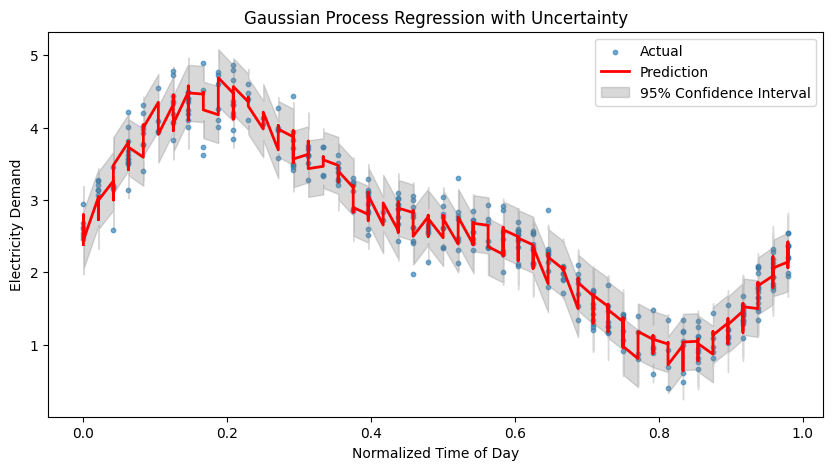

In [9]:
sorted_idx = np.argsort(X_test[:, 0])
X_plot = X_test[sorted_idx, 0]
y_plot = y_test[sorted_idx]
y_pred_plot = y_pred[sorted_idx]
y_std_plot = y_std[sorted_idx]

plt.figure(figsize=(10, 5))

plt.scatter(X_plot, y_plot, s=10, alpha=0.6, label="Actual")
plt.plot(X_plot, y_pred_plot, "r-", linewidth=2, label="Prediction")

plt.fill_between(
    X_plot,
    y_pred_plot - 2 * y_std_plot,
    y_pred_plot + 2 * y_std_plot,
    color="gray",
    alpha=0.3,
    label="95% Confidence Interval"
)

plt.xlabel("Normalized Time of Day")
plt.ylabel("Electricity Demand")
plt.title("Gaussian Process Regression with Uncertainty")
plt.legend()
plt.show()

### Residual Distribution

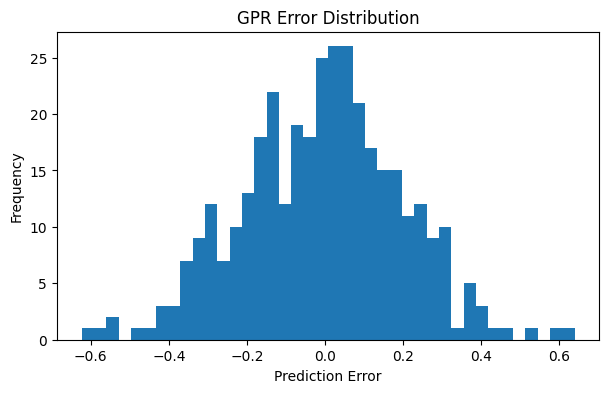

In [10]:
errors = y_test - y_pred

plt.figure(figsize=(7, 4))
plt.hist(errors, bins=40)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("GPR Error Distribution")
plt.show()

### Inspect Learned Kernel

In [11]:
print("Optimized Kernel:")
print(gpr.kernel_)

Optimized Kernel:
3.46**2 * RBF(length_scale=5.36) + WhiteKernel(noise_level=0.0282)


### Compare with Previous Models

In [12]:
print("Model Comparison")
print("-" * 40)
print(f"GPR MSE : {mse_gpr:.4f}")
print(f"GPR R²  : {r2_gpr:.4f}")

print("\nNote:")
print("GPR provides uncertainty estimates unlike SVR or RFF.")

Model Comparison
----------------------------------------
GPR MSE : 0.0417
GPR R²  : 0.9638

Note:
GPR provides uncertainty estimates unlike SVR or RFF.


### Limitations of GPR

- Computational complexity: **O(N³)**
- Memory-intensive for large datasets
- Not scalable without approximations

For large-scale forecasting:
- Use SVR
- Use Neural Networks
- Use Sparse GPR / inducing points